<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EC%A1%B8%ED%94%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1)데이터 불러오기

In [1]:
from scipy import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import librosa, librosa.display

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/My Drive/Colab Notebooks/data/vibration/vibration/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
global N, Fs, T
N=2000000
Fs=200000
T=10

## 2)데이터 구조 살피기

각 데이터에는 2개의 채널이 있습니다. 채널1은 가속도계에 의해 측정된 진동 데이터, 채널2는 인코더에 의해 측정된 회전속도 데이터입니다.

In [ ]:
mat_file = io.loadmat(file_path+'H-A-1.mat')
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 09 15:18:50 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_1': array([[-0.00219944],
        [-0.0018706 ],
        [-0.00154175],
        ...,
        [ 0.00963905],
        [ 0.0093102 ],
        [ 0.00898136]]),
 'Channel_2': array([[4.18876708],
        [4.20060302],
        [4.20816487],
        ...,
        [0.03700339],
        [0.03634584],
        [4.14010822]])}

## 3-1)데이터 전처리(FFT)

In [4]:
raw=[]
aug=[]
file_names=['H-A-1.mat','H-A-2.mat','H-A-3.mat','H-B-1.mat','H-B-2.mat','H-B-3.mat','H-C-1.mat','H-C-2.mat','H-C-3.mat','H-D-1.mat','H-D-2.mat','H-D-3.mat','I-A-1.mat','I-A-2.mat','I-A-3.mat','I-B-1.mat','I-B-2.mat','I-B-3.mat','I-C-1.mat','I-C-2.mat','I-C-3.mat','I-D-1.mat','I-D-2.mat','I-D-3.mat','O-A-1.mat','O-A-2.mat','O-A-3.mat','O-B-1.mat','O-B-2.mat','O-B-3.mat','O-C-1.mat','O-C-2.mat','O-C-3.mat','O-D-1.mat','O-D-2.mat','O-D-3.mat','B-A-1.mat','B-A-2.mat','B-A-3.mat','B-B-1.mat','B-B-2.mat','B-B-3.mat','B-C-1.mat','B-C-2.mat','B-C-3.mat','B-D-1.mat','B-D-2.mat','B-D-3.mat', 'C-A-1.mat','C-A-2.mat','C-A-3.mat','C-B-1.mat','C-B-2.mat','C-B-3.mat','C-C-1.mat','C-C-2.mat','C-C-3.mat','C-D-1.mat','C-D-2.mat','C-D-3.mat']

for i in range(60):
  mat_file = io.loadmat(file_path+file_names[i])['Channel_1']
  raw.append(mat_file)
  for j in range(1000):
    aug.append(mat_file[2000*j:2000*(j+1)])

raw=np.array(raw).reshape(60,2000000)
aug=np.array(aug).reshape(60000,2000)

#길이가 200만인 1개의 데이터를 길이가 2천인 1000개의 데이터로 분할함
#기존의 데이터(raw)는 10초동안 측정된 데이터이므로 분할된 데이터(aug)는 1/100초에 해당함

In [ ]:
raw_fft=[]

for i in range(60):
  fft=np.fft.fft(raw[i])/N
  raw_fft.append(fft)

raw_fft=np.array(raw_fft)

In [ ]:
aug_fft=[]

for i in range(60000):
  fft=np.fft.fft(aug[i])/2000
  aug_fft.append(fft[:1000])

aug_fft=np.array(aug_fft)

# 신호를 np.fft.fft() 함수로 푸리에 변환한다. 이때, 함수의 반환값을 신호의 길이로 나누어 normalization 해주어야 한다.
# magnitude를 얻기 위해 함수의 반환값에 abs()를 취한다.
# 푸리에 변환을 통해 주파수에 따른 magnitude와 angle을 구할 수 있는데, 반환값이 복소수 타입이기 때문이다.
# fft한 결과는 좌우대칭하므로 left에 해당하는 부분만 idexing 하여 데이터 크기를 줄인다.

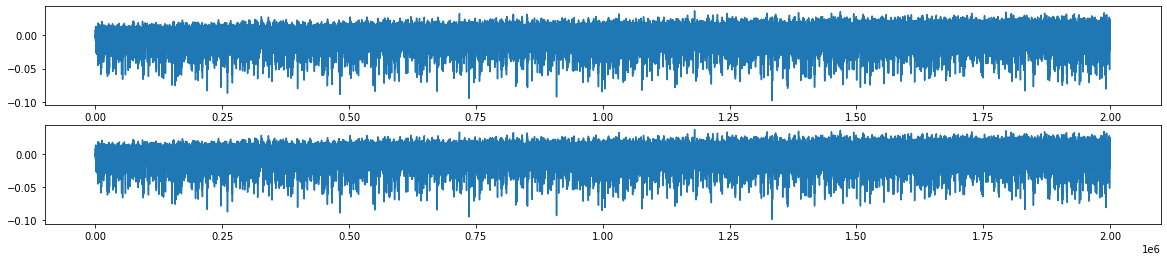

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(2,1,1); plt.plot(raw[0]);
plt.subplot(2,1,2); plt.plot(np.hstack(aug[0:1000]));
plt.show()

#### 참고

회귀 모델에 fft 데이터를 사용한다면 속도에 따른 y 변화를 고려해 스케일링 할 필요가 없음을 증명

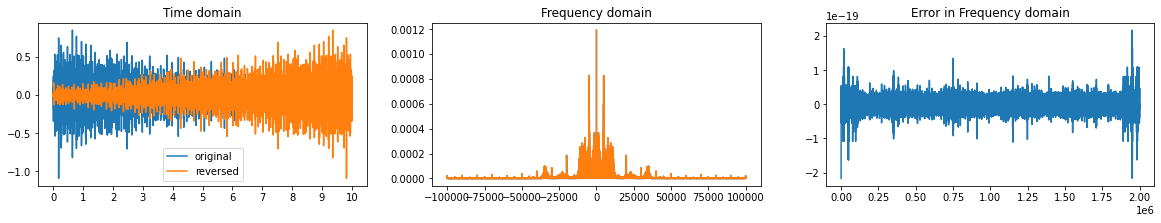

In [ ]:
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.title("Time domain")
plt.plot(raw[15]); plt.plot(raw[15][::-1])
plt.legend(['original', 'reversed'])
plt.xticks([0,200000,400000,600000,800000,1000000,1200000,1400000,1600000,1800000,2000000], [0,1,2,3,4,5,6,7,8,9,10])

plt.subplot(1,3,2)
plt.title("Frequency domain")
freq=np.fft.fftfreq(N, 1/Fs)
org=abs(raw_fft[15])
rev=abs(np.fft.fft(raw[15][::-1])/N)
plt.plot(freq, org); plt.plot(freq, rev)

plt.subplot(1,3,3)
plt.title("Error in Frequency domain")
plt.plot(org-rev)

#time domain에는 시간에 따라 y가 증가하는 데이터와 감소하는 데이터가 있다.
#따라서 감소하는 데이터를 좌우반전하여 증가하는 진동데이터로 만들어도, fft을 한 결과는 동일하다.
#frequency domain에서 최대 2.1684 e-19의 오차는 존재한다.

## 3-2)학습

- precision(정밀도) = TP/(TP+FP) = 정상예측 중 실제정상의 비율 => FP가 많을 수록 정밀도가 낮아지고, 고장진단 역할이 무의미함
- recall(재현율) = TP/(TP+FN) = 실제정상 중 정상예측의 비율

In [ ]:
x=pd.DataFrame(abs(aug_fft))
y=np.concatenate([np.ones(12000, int), np.zeros(48000, int)]) #정상은 1, 고장은 0
df=x
df['class']=y

#### ▶선형회귀 모델

keras로 구현한 회귀 알고리즘

##### 1)고장 여부에 따라

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [ ]:
train_dataset = df.sample(frac=0.8, random_state=0) #sample을 사용하여 데이터셋을 train과 test로 분할함
test_dataset = df.drop(train_dataset.index)
train_labels = train_dataset.pop('class') #pop을 사용하여 label에 해당하는 class cloumn을 제거하고 새로운 변수에 저장함
test_labels = test_dataset.pop('class')

In [ ]:
train_stats = train_dataset.describe().transpose() #feature들의 스케일과 범위가 다른 것을 정규화하기 위해 통계를 구함

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset) 
normed_test_data = norm(test_dataset)

In [ ]:
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
0,48000.0,0.004864,0.026548,4.940247e-08,0.000570,0.001200,0.002049,0.250876
1,48000.0,0.001286,0.000824,5.734480e-06,0.000680,0.001114,0.001713,0.007403
2,48000.0,0.001557,0.001112,5.116033e-06,0.000739,0.001259,0.002106,0.009634
3,48000.0,0.000684,0.000515,3.153886e-06,0.000325,0.000544,0.000894,0.005996
4,48000.0,0.000589,0.000461,1.772341e-06,0.000266,0.000461,0.000780,0.006405


In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse']) #평균절대오차와 평균제곱오차
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                32032     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(10,4))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
  plt.ylim([0,0.1])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
  plt.ylim([0,0.025])
  plt.legend()
  plt.show()

In [ ]:
history = model.fit(normed_train_data, train_labels, epochs=500, 
                    validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

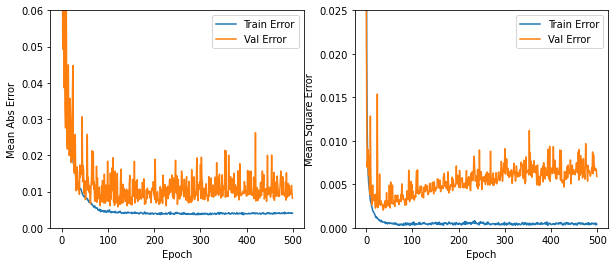

In [ ]:
plot_history(history)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
model = build_model()
history = model.fit(normed_train_data, train_labels, epochs=500,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


..........................

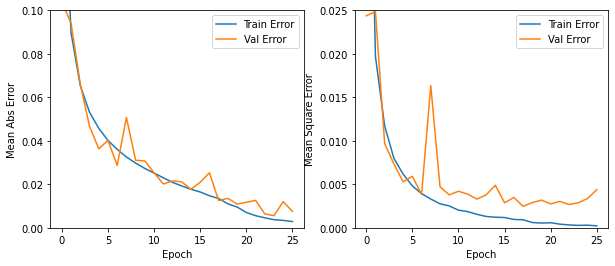

In [ ]:
plot_history(history)

평균적으로 epochs=25에서 early stopping함

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print() 
print("◎ 테스트 세트의 평균 절대 오차: {:5.4f}".format(mae))
print("◎ 테스트 세트의 평균 제곱 오차: {:5.4f}".format(mse))

375/375 - 1s - loss: 0.0054 - mae: 0.0084 - mse: 0.0054 - 615ms/epoch - 2ms/step

◎ 테스트 세트의 평균 절대 오차: 0.0084
◎ 테스트 세트의 평균 제곱 오차: 0.0054


375/375 [==============================] - 1s 2ms/step


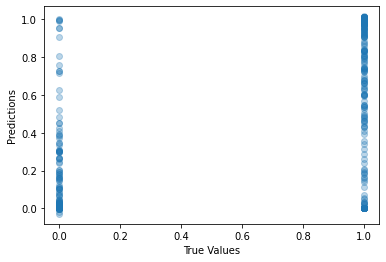

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
np.where(test_predictions<-0.5)

(array([], dtype=int64),)

10번의 학습 동안 예측값이 -3, -5, -6, -8, -12인 아웃라이어가 발생하였음

하지만 -0.5 미만인 예측값이 최소 0개, 최대 5개였기 때문에 negligible 하다 판단하여 별도의 처리 없이 0으로 대체함

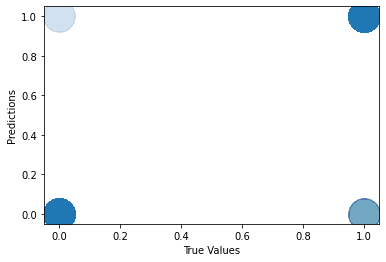

In [ ]:
pred=np.array([1 if i>=0.5 else 0 for i in list(test_predictions)])

plt.scatter(test_labels, pred, s=1000, alpha=0.01)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
print(confusion_matrix(test_labels, pred))
print()
print("◎ 테스트 세트의 정확도: {:5.4f}".format(metrics.accuracy_score(test_labels, pred)))
print("◎ 테스트 세트의 정밀도: {:5.4f}".format(metrics.precision_score(test_labels, pred)))
print("◎ 테스트 세트의 재현율: {:5.4f}".format(metrics.recall_score(test_labels, pred)))
print("◎ 테스트 세트의 f1: {:5.4f}".format(metrics.f1_score(test_labels, pred)))

[[9585   15]
 [  61 2339]]

◎ 테스트 세트의 정확도: 0.9937
◎ 테스트 세트의 정밀도: 0.9936
◎ 테스트 세트의 재현율: 0.9746
◎ 테스트 세트의 f1: 0.9840


[[9556   44]
 [  13 2387]]

◎ 테스트 세트의 정확도: 0.9952
◎ 테스트 세트의 정밀도: 0.9819
◎ 테스트 세트의 재현율: 0.9946
◎ 테스트 세트의 f1: 0.9882

[[9561   39]
 [  19 2381]]

◎ 테스트 세트의 정확도: 0.9952
◎ 테스트 세트의 정밀도: 0.9839
◎ 테스트 세트의 재현율: 0.9921
◎ 테스트 세트의 f1: 0.9880

[[9581   19]
 [  24 2376]]

◎ 테스트 세트의 정확도: 0.9964
◎ 테스트 세트의 정밀도: 0.9921
◎ 테스트 세트의 재현율: 0.9900
◎ 테스트 세트의 f1: 0.9910

[[9539   61]
 [  10 2390]]

◎ 테스트 세트의 정확도: 0.9941
◎ 테스트 세트의 정밀도: 0.9751
◎ 테스트 세트의 재현율: 0.9958
◎ 테스트 세트의 f1: 0.9854

[[9527   73]
 [   7 2393]]

◎ 테스트 세트의 정확도: 0.9933
◎ 테스트 세트의 정밀도: 0.9704
◎ 테스트 세트의 재현율: 0.9971
◎ 테스트 세트의 f1: 0.9836

[[9515   85]
 [  48 2352]]

◎ 테스트 세트의 정확도: 0.9889
◎ 테스트 세트의 정밀도: 0.9651
◎ 테스트 세트의 재현율: 0.9800
◎ 테스트 세트의 f1: 0.9725

 *** early stopping의 patience를 10에서 8로 줄였음(모델 성능이 떨어지는 것 같아서)

[[9582   18]
 [  16 2384]]

◎ 테스트 세트의 정확도: 0.9972
◎ 테스트 세트의 정밀도: 0.9925
◎ 테스트 세트의 재현율: 0.9933
◎ 테스트 세트의 f1: 0.9929

[[9566   34]
 [  20 2380]]

◎ 테스트 세트의 정확도: 0.9955
◎ 테스트 세트의 정밀도: 0.9859
◎ 테스트 세트의 재현율: 0.9917
◎ 테스트 세트의 f1: 0.9888

[[9564   36]
 [  10 2390]]

◎ 테스트 세트의 정확도: 0.9962
◎ 테스트 세트의 정밀도: 0.9852
◎ 테스트 세트의 재현율: 0.9958
◎ 테스트 세트의 f1: 0.9905

[[9585   15]
 [  61 2339]]

◎ 테스트 세트의 정확도: 0.9937
◎ 테스트 세트의 정밀도: 0.9936
◎ 테스트 세트의 재현율: 0.9746
◎ 테스트 세트의 f1: 0.9840

In [ ]:
print("◎ 평균 정확도: {:5.4f}".format( (0.9952+0.9952+0.9964+0.9941+0.9933+0.9889+0.9972+0.9955+0.9962+0.9937)/10 ))
print("◎ 평균 f1: {:5.4f}".format( (0.9882+0.9880+0.9910+0.9854+0.9836+0.9725+0.9929+0.9888+0.9905+0.9840)/10 ))

◎ 평균 정확도: 0.9946
◎ 평균 f1: 0.9865


각 지표가 가장 높은 경우의 FP와 FN
- 정밀도(0.9936): 15, 61

- 재현율(0.9971): 73, 7 

- f1스코어(0.9929): 18, 16

정밀도나 재현율 중 어느 한쪽만 높이면 반대쪽이 극단적으로 낮아지는 trade-off가 발생함

f1스코어가 높고 정밀도가 높은 모델이 고장 진단 성능이 좋다고 볼 수 있음

##### 2)고장 종류에 따라(실행x)

In [ ]:
x=pd.DataFrame(abs(aug_fft))
y=np.concatenate([np.ones(12000, int), np.ones(12000, int)*2, np.ones(12000, int)*3, np.ones(12000, int)*4, np.ones(12000, int)*5]) #고장 종류에 따라 1,2,3,4,5 (하지만 이산형이 아닌 명목형 자료)
df=x
df['class']=y

375/375 [==============================] - 2s 5ms/step


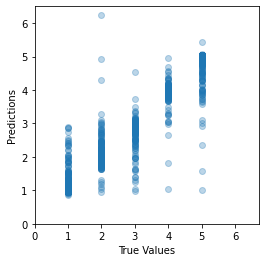

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.3)
plt.axis('square')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.show()

In [ ]:
pred=[]
for i in list(test_predictions):
  if i>=5.5: i=6
  elif i>=4.5: i=5
  elif i>=3.5: i=4
  elif i>=2.5: i=3
  elif i>=1.5: i=2
  elif i>=0.5: i=1
  else: i==0
  pred.append(i)

pred=np.array(pred)

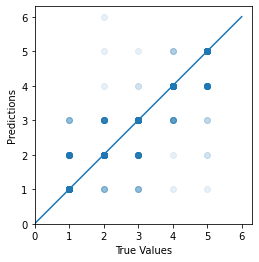

In [ ]:
plt.scatter(test_labels, pred, alpha=0.1)
plt.plot([0,6], [0,6])
plt.axis('square')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.show()

In [ ]:
print(confusion_matrix(test_labels, pred))
print()
print("◎ 테스트 세트의 정확도: {:5.4f}".format(metrics.accuracy_score(test_labels, pred)))

[[2361   33    6    0    0    0]
 [   6 2374   21    1    1    1]
 [   6   25 2327    2    1    0]
 [   1    1   11 2366    4    0]
 [   1    2    3   31 2415    0]
 [   0    0    0    0    0    0]]

◎ 테스트 세트의 정확도: 0.9869


예측값에 대해 정답값±0.5의 임계값을 취했을 때 평균 0.9862의 정확도를 가짐(표본 4개)

대체로 inner race에 결함이 있는 베어링에 대한 예측 정확도가 낮음

[[2359   32    9    0    0]
 [  11 2367   19    5    2]
 [  10   28 2320    3    0]
 [   1    2   15 2364    1]
 [   0    1    2   19 2430]]

◎ 테스트 세트의 정확도: 0.9867

[[2349   40   11    0    0    0]
 [   6 2372   19    3    3    1]
 [   9   24 2323    3    2    0]
 [   0    2    6 2361   14    0]
 [   0    0    4   27 2420    1]
 [   0    0    0    0    0    0]]

◎ 테스트 세트의 정확도: 0.9854

[[2382   17    1    0    0]
 [   9 2367   22    5    1]
 [   7   49 2299    5    1]
 [   0    4   13 2365    1]
 [   0    1    1   24 2426]]

◎ 테스트 세트의 정확도: 0.9866

[[2378   20    2    0    0    0]
 [   5 2368   19    3    7    2]
 [   8   56 2296    0    1    0]
 [   1    4   18 2356    4    0]
 [   0    0    3   14 2435    0]
 [   0    0    0    0    0    0]]

◎ 테스트 세트의 정확도: 0.9861

#### ▶로지스틱 회귀 모델(실패)

scikit-learn으로 구현한 분류 알고리즘

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

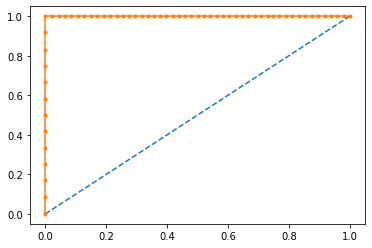

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='class'], df['class'], random_state=1)

scaler=StandardScaler()
x_train, x_test=scaler.fit_transform(X_train), scaler.transform(X_test)

clf=LogisticRegression()
clf.fit(x_train, y_train)

pred=clf.predict(x_test)
prob=clf.predict_proba(x_test)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prob[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()


In [ ]:
confusion_matrix(y_test, pred)

array([[12028,     0],
       [    0,  2972]])

크기가 784인 이미지와 실제 숫자값을 갖는 데이터가 7만개인 mnist와 비슷하게

크기가 1000인 신호와 실제 정상여부 값을 갖는 데이터 6만개


In [ ]:
df['class'].value_counts()

0    48000
1    12000
Name: class, dtype: int64

#### ▶DNN 모델

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='class'], df['class'], random_state=1)

model=Sequential()
model.add(Dense(800, input_dim=1000, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #이진분류에 가장 많이 사용되는 활성화함수

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
list(y_train).count(1)+list(y_test).count(1)

12000

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 800)               800800    
                                                                 
 dense_41 (Dense)            (None, 250)               200250    
                                                                 
 dense_42 (Dense)            (None, 10)                2510      
                                                                 
 dense_43 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,003,571
Trainable params: 1,003,571
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train, y_train, validation_split=0.25, epochs=20, batch_size=600)

Epoch 1/20
57/57 [==============================] - 5s 75ms/step - loss: 0.5056 - accuracy: 0.7999 - val_loss: 0.4418 - val_accuracy: 0.8028
Epoch 2/20
57/57 [==============================] - 4s 71ms/step - loss: 0.3762 - accuracy: 0.8029 - val_loss: 0.3074 - val_accuracy: 0.8028
Epoch 3/20
57/57 [==============================] - 4s 70ms/step - loss: 0.2399 - accuracy: 0.8988 - val_loss: 0.1911 - val_accuracy: 0.8990
Epoch 4/20
57/57 [==============================] - 4s 71ms/step - loss: 0.1295 - accuracy: 0.9783 - val_loss: 0.0816 - val_accuracy: 0.9898
Epoch 5/20
57/57 [==============================] - 4s 70ms/step - loss: 0.0484 - accuracy: 0.9921 - val_loss: 0.0289 - val_accuracy: 0.9925
Epoch 6/20
57/57 [==============================] - 4s 71ms/step - loss: 0.0258 - accuracy: 0.9935 - val_loss: 0.0300 - val_accuracy: 0.9902
Epoch 7/20
57/57 [==============================] - 4s 71ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 0.0169 - val_accuracy: 0.9953
Epoch 8/20
57

##### 1)정확도, 정밀도 계산

In [ ]:
def acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  #plt.title('Model accuracy')
  #plt.xlabel('Epoch')
  #plt.ylabel('Accuracy')
  plt.ylim(0.98,1)
  plt.legend(['Train', 'Validation'], loc='upper left')

def loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  #plt.ylim(0.98,1)
  plt.legend(['Train', 'Validation'], loc='upper left')

def res(model):
  pred=model.predict(X_test)
  pred=np.array([0 if i<0.5 else 1 for i in pred])
  print(confusion_matrix(y_test, pred))
  print(model.evaluate(X_test, y_test))
  print(metrics.precision_score(y_test, pred)) #정밀도를 계산해주는 메서드
  return pred

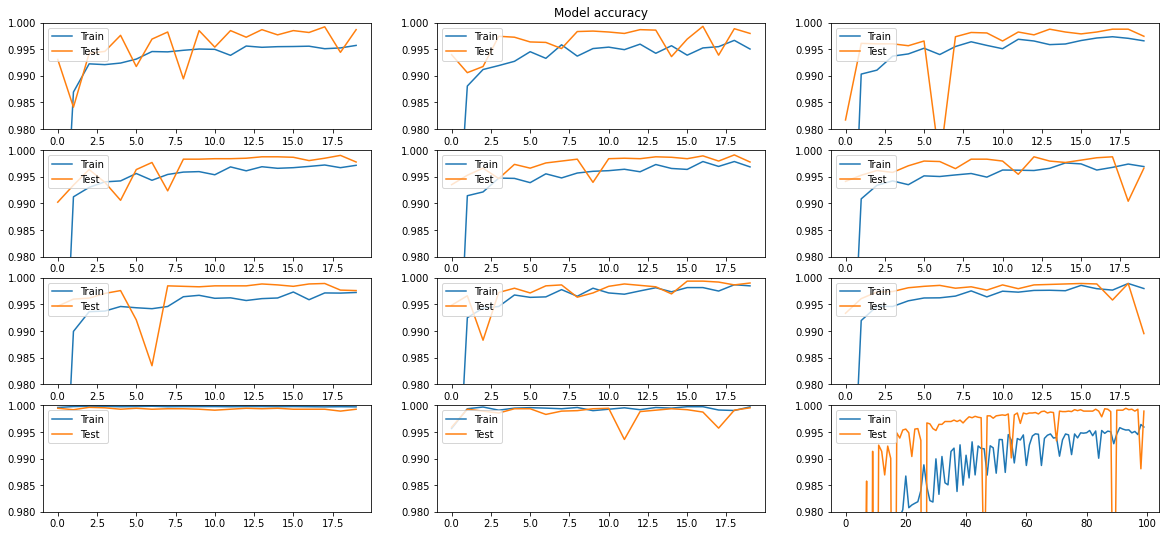

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(4,3,1); acc(history1)
plt.subplot(4,3,2); acc(history2); plt.title('Model accuracy')
plt.subplot(4,3,3); acc(history3)
plt.subplot(4,3,4); acc(history4)
plt.subplot(4,3,5); acc(history5)
plt.subplot(4,3,6); acc(history6)
plt.subplot(4,3,7); acc(history7)
plt.subplot(4,3,8); acc(history8)
plt.subplot(4,3,9); acc(history9)
plt.subplot(4,3,10); acc(history10)
plt.subplot(4,3,11); acc(history11)
plt.subplot(4,3,12); acc(history12)

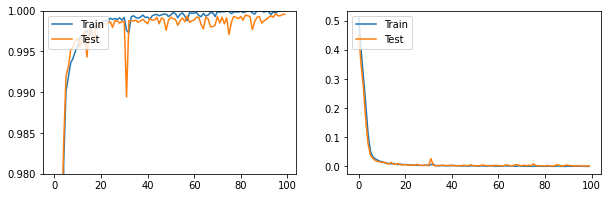

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); acc(history)
plt.subplot(1,2,2); loss(history)

나와 비슷한 케이스 https://datascience.stackexchange.com/questions/111264/how-to-analyse-the-accuracy-and-loss-graphs-of-model-history

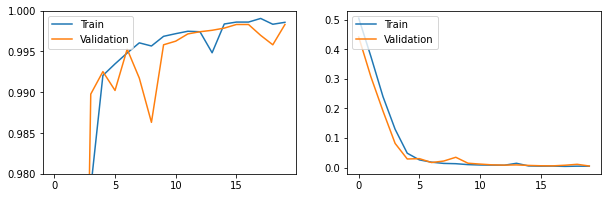

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); acc(history)
plt.subplot(1,2,2); loss(history)

In [ ]:
pred=res(model)

#confusion matrix의 구조는 TN(고장예측 실제고장), FP(정상예측 실제고장)
#                          FN(고장예측 실제정상), TP(정상예측 실제정상)
#고장을 정상으로 잘못 예측한 경우가 많다. 이러면 의미가 없다.

469/469 [==============================] - 2s 5ms/step
[[11858    12]
 [    9  3121]]
469/469 [==============================] - 3s 5ms/step - loss: 0.0043 - accuracy: 0.9986
[0.0042818812653422356, 0.9986000061035156]
0.9971246006389777


In [ ]:
temp=list(y_test)
print(temp.count(0), temp.count(1))

11870 3130


##### 2)오분류 시각화

In [ ]:
def wrong(F_):
  plt.figure(figsize=(24,4))
  for i in range(len(F_)):
    idx=F_[i]
    plt.subplot(1,len(F_),i+1)
    plt.plot(abs(aug_fft[idx]))
    a=list(y_test)[idx]
    b=list(pred)[idx]
    plt.title(str(a)+'(predict:'+str(b)+')', color="red")

In [ ]:
FP=[i for i in range(15000) if list(y_test)[i]==0 and list(pred)[i]==1]

In [ ]:
FN=[i for i in range(15000) if list(y_test)[i]==1 and list(pred)[i]==0]

[3031, 7234, 7975]

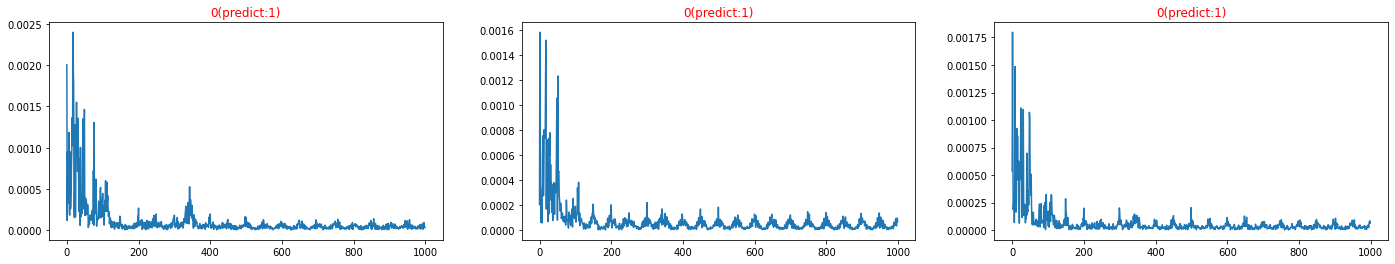

In [ ]:
wrong(FP); FP

[187, 1504, 1531, 2574, 2812, 10463, 10674, 11038, 12840, 13421, 13758]

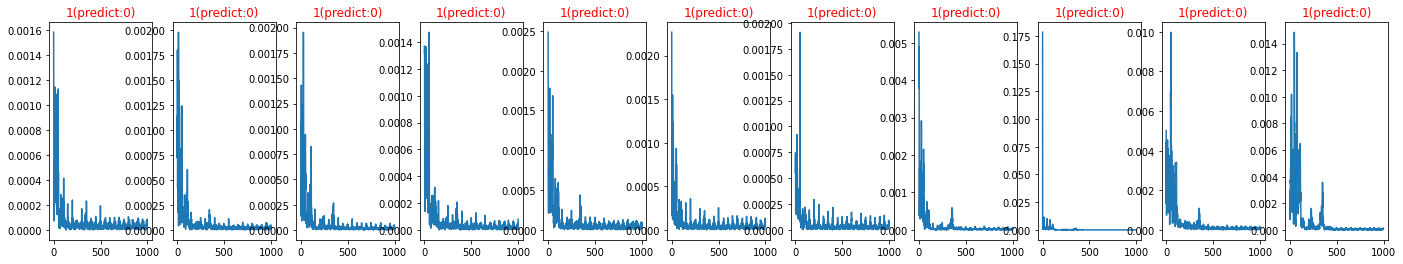

In [ ]:
wrong(FN); FN

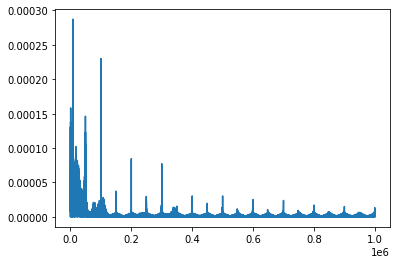

In [ ]:
mat_file=io.loadmat(file_path+'H-C-3.mat')['Channel_1'].reshape(N) #3031번째 aug data의 raw data
mat_fft=(np.fft.fft(mat_file)/N)[:N//2]
plt.plot(abs(mat_fft))

#### ▶스태킹 앙상블 모델

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold

In [ ]:
#개별모델
knn  = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
randomforest = RandomForestClassifier(n_estimators=100, random_state=100)
tree = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=100)
adaboost = AdaBoostClassifier(n_estimators=100, random_state=100)

In [ ]:
#최종 메타모델
logistic_meta = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, random_state=100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='class'], df['class'], random_state=1)

knn.fit(X_train, y_train)
randomforest.fit(X_train , y_train)
tree.fit(X_train , y_train)           #~3분 소요
adaboost.fit(X_train, y_train)        #~14분 소요

AdaBoostClassifier(n_estimators=100, random_state=100)

In [ ]:
knn.fit(X_train, y_train)
randomforest.fit(X_train , y_train)
tree.fit(X_train , y_train)       #~4분 소요
adaboost.fit(X_train, y_train)    #~14분 소요

AdaBoostClassifier(n_estimators=100, random_state=100)

In [ ]:
knn_pred = knn.predict(X_test)
randomforest_pred = randomforest.predict(X_test)
tree_pred = tree.predict(X_test)
adaboost_pred = adaboost.predict(X_test)

print('◎ KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('◎ RandomForest 정확도: {0:.4f}'.format(accuracy_score(y_test, randomforest_pred)))
print('◎ DecisionTree 정확도: {0:.4f}'.format(accuracy_score(y_test, tree_pred)))
print('◎ AdaBoost 정확도: {0:.4f} '.format(accuracy_score(y_test, adaboost_pred)))

◎ KNN 정확도: 0.9954
◎ RandomForest 정확도: 0.9820
◎ DecisionTree 정확도: 0.9409
◎ AdaBoost 정확도: 0.9945 


knn과 adaboost의 정확도가 높고, decision tree가 떨어짐

In [ ]:
pred = np.array([knn_pred, randomforest_pred, tree_pred, adaboost_pred])
print('◎ 변경 전 = ', pred.shape)

pred = np.transpose(pred)
print('◎ 변경 후 = ',pred.shape)

◎ 변경 전 =  (4, 15000)
◎ 변경 후 =  (15000, 4)


In [ ]:
logistic_meta.fit(pred, y_test)
final = logistic_meta.predict(pred)

print('◎ 최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

◎ 최종 메타 모델의 예측 정확도: 0.9971


In [ ]:
def get_stacking_base_datasets(model, X_train_data, y_train_data, X_test_data, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=False) #n_folds개로 분할하여 KFold 생성
    
    train_fold_pred = np.zeros((X_train_data.shape[0] ,1 )) #빈 배열 생성
    test_pred = np.zeros((X_test_data.shape[0],n_folds))
    print('▶ ', model.__class__.__name__ , ' model 시작 ')
    
    for fold_counter , (train_index, valid_index) in enumerate(kf.split(X_train_data)):
        print('\t Fold Set: ',fold_counter,' 시작 ')
        X_train_fold = X_train_data.iloc[train_index] #모델이 학습/예측할 fold 데이터셋 추출
        y_train_fold = y_train_data.iloc[train_index] 
        X_val_fold = X_train_data.iloc[valid_index]  
        
        model.fit(X_train_fold , y_train_fold) #모델 학습
        train_fold_pred[valid_index, :] = model.predict(X_val_fold).reshape(-1,1)
        test_pred[:, fold_counter] = model.predict(X_test_data) #모델 예측 후 예측값 저장
            
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    return train_fold_pred , test_pred_mean #최종모델이 사용할 train data와 test data

개별모델로부터, 최종모델이 사용할 데이터를 생성하는 함수

In [ ]:
# 1시간 10분 소요
knn_train, knn_test = get_stacking_base_datasets(knn, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(randomforest, X_train, y_train, X_test, 7)
tree_train, tree_test = get_stacking_base_datasets(tree, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(adaboost, X_train, y_train, X_test, 7)

▶  KNeighborsClassifier  model 시작 
	 Fold Set:  0  시작 
	 Fold Set:  1  시작 
	 Fold Set:  2  시작 
	 Fold Set:  3  시작 
	 Fold Set:  4  시작 
	 Fold Set:  5  시작 
	 Fold Set:  6  시작 
▶  RandomForestClassifier  model 시작 
	 Fold Set:  0  시작 
	 Fold Set:  1  시작 
	 Fold Set:  2  시작 
	 Fold Set:  3  시작 
	 Fold Set:  4  시작 
	 Fold Set:  5  시작 
	 Fold Set:  6  시작 
▶  DecisionTreeClassifier  model 시작 
	 Fold Set:  0  시작 
	 Fold Set:  1  시작 
	 Fold Set:  2  시작 
	 Fold Set:  3  시작 
	 Fold Set:  4  시작 
	 Fold Set:  5  시작 
	 Fold Set:  6  시작 
▶  AdaBoostClassifier  model 시작 
	 Fold Set:  0  시작 
	 Fold Set:  1  시작 
	 Fold Set:  2  시작 
	 Fold Set:  3  시작 
	 Fold Set:  4  시작 
	 Fold Set:  5  시작 
	 Fold Set:  6  시작 


In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, tree_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, tree_test, ada_test), axis=1)

print('◎ 원본 학습용, 테스트용 데이터 Shape:', X_train.shape, X_test.shape)
print('◎ 스태킹 학습용, 테스트용 데이터 Shape:', Stack_final_X_train.shape, Stack_final_X_test.shape)

◎ 원본 학습용, 테스트용 데이터 Shape: (45000, 1000) (15000, 1000)
◎ 스태킹 학습용, 테스트용 데이터 Shape: (45000, 4) (15000, 4)


In [ ]:
logistic_meta.fit(Stack_final_X_train, y_train)
stack_final = logistic_meta.predict(Stack_final_X_test)

print(confusion_matrix(y_test, stack_final))
print()
print("◎ 최종 메타 모델의 정확도: {:5.4f}".format(accuracy_score(y_test, stack_final)))
print("◎ 최종 메타 모델의 정밀도: {:5.4f}".format(precision_score(y_test, stack_final)))
print("◎ 최종 메타 모델의 재현율: {:5.4f}".format(recall_score(y_test, stack_final)))
print("◎ 최종 메타 모델의 f1: {:5.4f}".format(f1_score(y_test, stack_final)))

[[11862     8]
 [   22  3108]]

◎ 최종 메타 모델의 정확도: 0.9980
◎ 최종 메타 모델의 정밀도: 0.9974
◎ 최종 메타 모델의 재현율: 0.9930
◎ 최종 메타 모델의 f1: 0.9952


KFold 교차검증의 결과로, 예측 정확도가 0.9971에서 0.9980으로 약 0.1 증가하였음

#### ▶LightGBM 모델

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
df['class'].value_counts()

0    48000
1    12000
Name: class, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='class'], df['class'], random_state=1)

lgbm_model = LGBMClassifier(n_estimators=300, learning_rate=0.15)

lgbm_model.fit(X_train, y_train, early_stopping_rounds=50, 
               eval_metric="logloss", 
               eval_set=[(X_test, y_test)], 
               verbose=True)

preds = lgbm_model.predict(X_test)
pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.404682	valid_0's binary_logloss: 0.404682
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.338664	valid_0's binary_logloss: 0.338664
[3]	valid_0's binary_logloss: 0.290997	valid_0's binary_logloss: 0.290997
[4]	valid_0's binary_logloss: 0.254503	valid_0's binary_logloss: 0.254503
[5]	valid_0's binary_logloss: 0.225408	valid_0's binary_logloss: 0.225408
[6]	valid_0's binary_logloss: 0.200831	valid_0's binary_logloss: 0.200831
[7]	valid_0's binary_logloss: 0.17919	valid_0's binary_logloss: 0.17919
[8]	valid_0's binary_logloss: 0.160593	valid_0's binary_logloss: 0.160593
[9]	valid_0's binary_logloss: 0.145087	valid_0's binary_logloss: 0.145087
[10]	valid_0's binary_logloss: 0.131021	valid_0's binary_logloss: 0.131021
[11]	valid_0's binary_logloss: 0.118785	valid_0's binary_logloss: 0.118785
[12]	valid_0's binary_logloss: 0.108011	valid_0's binary_logloss: 0.108011
[13]	valid_0's binary_logloss: 0.0987662	valid_0'

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    confmat = pd.DataFrame(confusion, index=['True[0]', 'True[1]'], columns = ['Predict[0]', 'Predict[1]'])
    print(confmat)
    print()
    print('◎ 정확도: {0:.4f} ◎ 정밀도: {1:.4f} ◎ 재현율: {2:.4f}  ◎ F1: {3:.4f} ◎ AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    

In [ ]:
get_clf_eval(y_test, preds, pred_proba) #300, 0.1

         Predict[0]  Predict[1]
True[0]       11867           3
True[1]           5        3125

◎ 정확도: 0.9995 ◎ 정밀도: 0.9990 ◎ 재현율: 0.9984  ◎ F1: 0.9987 ◎ AUC:1.0000


In [ ]:
get_clf_eval(y_test, preds, pred_proba) #300, 0.15

         Predict[0]  Predict[1]
True[0]       11868           2
True[1]           3        3127

◎ 정확도: 0.9997 ◎ 정밀도: 0.9994 ◎ 재현율: 0.9990  ◎ F1: 0.9992 ◎ AUC:1.0000


n_estimators=400으로 설정해도 307에서 early stopping 하고 257이 best iteration 이었음

지금까지 학습한 모든 모델을 통틀어 FP와 FN이 가장 낮은 결과임


## 4-1)데이터 전처리(STFT)

#### 스펙트로그램

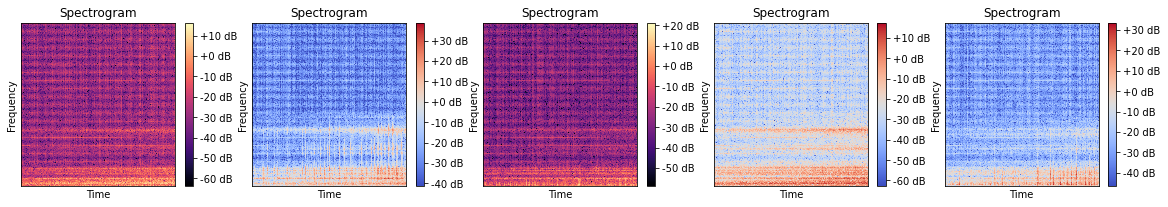

In [68]:
sc=2

plt.figure(figsize=(20,3))
for i in range(5):
  plt.subplot(1,5,i+1)
  magnitude = np.abs(librosa.stft(raw[sc+12*i])) #순서대로 정상 베어링과 inner race, outer race, ball, combinnation 결함이 있는 베어링의 진동 데이터
  log_spectrogram = librosa.amplitude_to_db(magnitude)
  librosa.display.specshow(log_spectrogram, sr=Fs)
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.colorbar(format="%+2.0f dB")
  plt.title("Spectrogram")

#sc은 speed condition을 선택하는 변수임
#0,1,2이면 증가, 3,4,5면 감소, 6,7,8이면 증가후감소, 9,10,11이면 감소후증가

In [101]:
a=librosa.stft(raw[0]) #1 => 10s
b=librosa.stft(raw[0][0:40000]) #1/50 => 0.5s
c=librosa.stft(raw[0][0:20000]) #1/100 => 0.1s
d=librosa.stft(aug[0]) #1/1000 => 0.01s

In [102]:
a.shape, b.shape, c.shape, d.shape

((1025, 3907), (1025, 79), (1025, 40), (1025, 4))

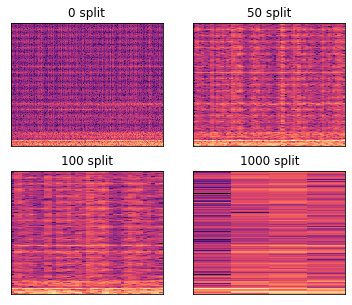

In [84]:
plt.figure(figsize=(6,5))
plt.subplot(2,2,1); plt.title('0 split'); librosa.display.specshow(librosa.amplitude_to_db(abs(a)), sr=Fs)
plt.subplot(2,2,2); plt.title('50 split'); librosa.display.specshow(librosa.amplitude_to_db(abs(b)), sr=Fs)
plt.subplot(2,2,3); plt.title('100 split'); librosa.display.specshow(librosa.amplitude_to_db(abs(c)), sr=Fs)
plt.subplot(2,2,4); plt.title('1000 split'); librosa.display.specshow(librosa.amplitude_to_db(abs(d)), sr=Fs)
plt.show()

## 4-2)학습

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import confusion_matrix, accuracy_score

#### 10split (600)

In [6]:
stft10=[]
for i in range(60):
  for j in range(10):
    stft10.append( abs(librosa.stft( raw[i][200000*j:200000*(j+1)])) )
stft10=np.array(stft10)
stft10=(stft10-stft10.min())/(stft10.max()-stft10.min())

In [7]:
y10=np.concatenate([np.zeros(120, int), np.ones(120, int), np.ones(120, int)*2, np.ones(120, int)*3, np.ones(120, int)*4])

#### 50split (3000, 1025, 79)

In [6]:
stft50=[]
for i in range(60):
  for j in range(50):
    stft50.append( abs(librosa.stft( raw[i][40000*j:40000*(j+1)])) )
stft50=np.array(stft50)
stft50=(stft50-stft50.min())/(stft50.max()-stft50.min())

In [7]:
y50=np.concatenate([np.zeros(600, int), np.ones(600, int), np.ones(600, int)*2, np.ones(600, int)*3, np.ones(600, int)*4]) #고장 종류에 따라 0,1,2,3,4

#### 100split (6000, 1025, 40)

In [6]:
stft100=[]
for i in range(60):
  for j in range(100):
    stft100.append( abs(librosa.stft( raw[i][20000*j:20000*(j+1)])) )
stft100=np.array(stft100)
stft100=(stft100-stft100.min())/(stft100.max()-stft100.min())

In [7]:
y100=np.concatenate([np.zeros(1200, int), np.ones(1200, int), np.ones(1200, int)*2, np.ones(1200, int)*3, np.ones(1200, int)*4])

#### 200split (12000, 1025, 20)

In [6]:
stft200=[]
for i in range(60):
  for j in range(200):
    stft200.append( abs(librosa.stft( raw[i][10000*j:10000*(j+1)])) )
stft200=np.array(stft200)
stft200=(stft200-stft200.min())/(stft200.max()-stft200.min())

In [8]:
y200=np.concatenate([np.zeros(2400, int), np.ones(2400, int), np.ones(2400, int)*2, np.ones(2400, int)*3, np.ones(2400, int)*4]) #고장 종류에 따라 0,1,2,3,4

#### 모델

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(stft100, y100, random_state=100)

train_oh_labels = to_categorical(train_labels)
test_oh_labels = to_categorical(test_labels)

print("◎ train dataset shape:", train_images.shape, train_labels.shape, '->', train_oh_labels.shape)
print("◎ test dataset shape:", test_images.shape, test_labels.shape, '->', test_oh_labels.shape)

◎ train dataset shape: (4500, 1025, 40) (4500,) -> (4500, 5)
◎ test dataset shape: (1500, 1025, 40) (1500,) -> (1500, 5)


In [10]:
tr_images, val_images, tr_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.15, random_state=100)

tr_oh_labels = to_categorical(tr_labels)
val_oh_labels = to_categorical(val_labels)

print('◎ train shape:', tr_images.shape, tr_labels.shape, '->', tr_oh_labels.shape)
print('◎ validation shape:', val_images.shape, val_labels.shape, '->', val_oh_labels.shape)

◎ train shape: (3825, 1025, 40) (3825,) -> (3825, 5)
◎ validation shape: (675, 1025, 40) (675,) -> (675, 5)


In [11]:
model = Sequential([
    Flatten(input_shape=(train_images[0].shape)),
    Dense(100, activation='relu'),
    Dense(30, activation='relu'),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41000)             0         
                                                                 
 dense (Dense)               (None, 100)               4100100   
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 5)                 155       
                                                                 
Total params: 4,103,285
Trainable params: 4,103,285
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
report = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, 
                   validation_data=(val_images, val_oh_labels), 
                    epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 27ms/step - loss: 1.3203 - accuracy: 0.3697 - val_loss: 1.1197 - val_accuracy: 0.6430
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.8816 - accuracy: 0.8515 - val_loss: 0.6673 - val_accuracy: 0.9452
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4524 - accuracy: 0.9856 - val_loss: 0.2957 - val_accuracy: 0.9896
Epoch 4/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1870 - accuracy: 0.9979 - val_loss: 0.1255 - val_accuracy: 0.9926
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0801 - accuracy: 0.9995 - val_loss: 0.0622 - val_accuracy: 0.9956
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0413 - accuracy: 0.9995 - val_loss: 0.0381 - val_accuracy: 1.0000
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 0.9985
Epoch 8/20
30

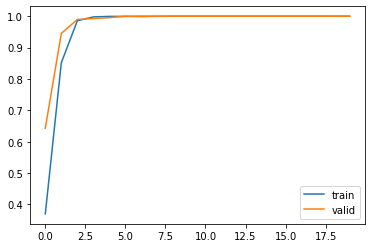

In [14]:
plt.plot(report.history['accuracy'], label='train')
plt.plot(report.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

In [15]:
class_names = ['healthy', 'inner', 'outer', 'ball', 'combination']

def plot_image(i, predictions_array, true_label, img):
  
  #실제라벨, 실제이미지, 예측라벨 저장
  true_label, img = int(true_label[i]), img[i]
  predicted_label = np.argmax(predictions_array) #예측 확률에서 가장 큰 값의 위치를 반환

  #스펙트로그램 시각화
  librosa.display.specshow(librosa.amplitude_to_db(img), sr=Fs)

  #예측값, 예측확률, 정답값 출력
  if predicted_label == true_label: color = 'blue'
  else: color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
  
def plot_value_array(i, predictions_array, true_label):
  
  #실제라벨과 예측라벨 저장
  true_label = int(true_label[i])
  predicted_label = np.argmax(predictions_array)

  #예측확률 시각화
  plt.xticks(range(5))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, width=0.4, color="#777777")

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [16]:
pred_proba = model.predict(test_images)
pred_label=[]
for i in range(len(test_labels)): pred_label.append(np.argmax(pred_proba[i]))
print()
print(confusion_matrix(test_labels, pred_label))
print()
print('◎ 정확도: {0:.4f}'.format(accuracy_score(test_labels, pred_label)))

47/47 [==============================] - 0s 4ms/step

[[306   0   0   0   0]
 [  0 308   1   0   0]
 [  0   0 282   0   0]
 [  0   0   0 305   0]
 [  0   0   0   0 298]]

◎ 정확도: 0.9993


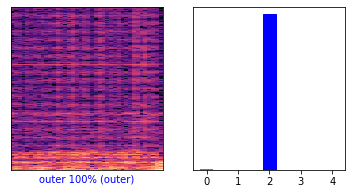

In [17]:
i=10

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plot_image(i, pred_proba[i], test_labels, test_images)
plt.subplot(1,2,2); plot_value_array(i, pred_proba[i],  test_labels)
plt.show()

In [18]:
model.evaluate(test_images, test_oh_labels, batch_size=64)

24/24 [==============================] - 0s 7ms/step - loss: 0.0036 - accuracy: 0.9993


[0.0036250900011509657, 0.9993333220481873]

- validation data를 사용하지 않았을 때

정확도: 200split만 0.9993, 나머지는 1.0

loss: 100split이 0.0003, 50split이 0.00066, 10split은 13배~41배

- validation data를 사용하였을 때

정확도: 50split만 0.9993, 나머지는 1.0

loss: 200split이 0.0013, 100split이 0.00362, 10split은 18배~103배

결과적으로 100split이 우수한 고장진단 및 고장유형 분류 성능을 보임을 알 수 있음.

## 5)데이터 시각화

#### 베어링 상태별 그래프

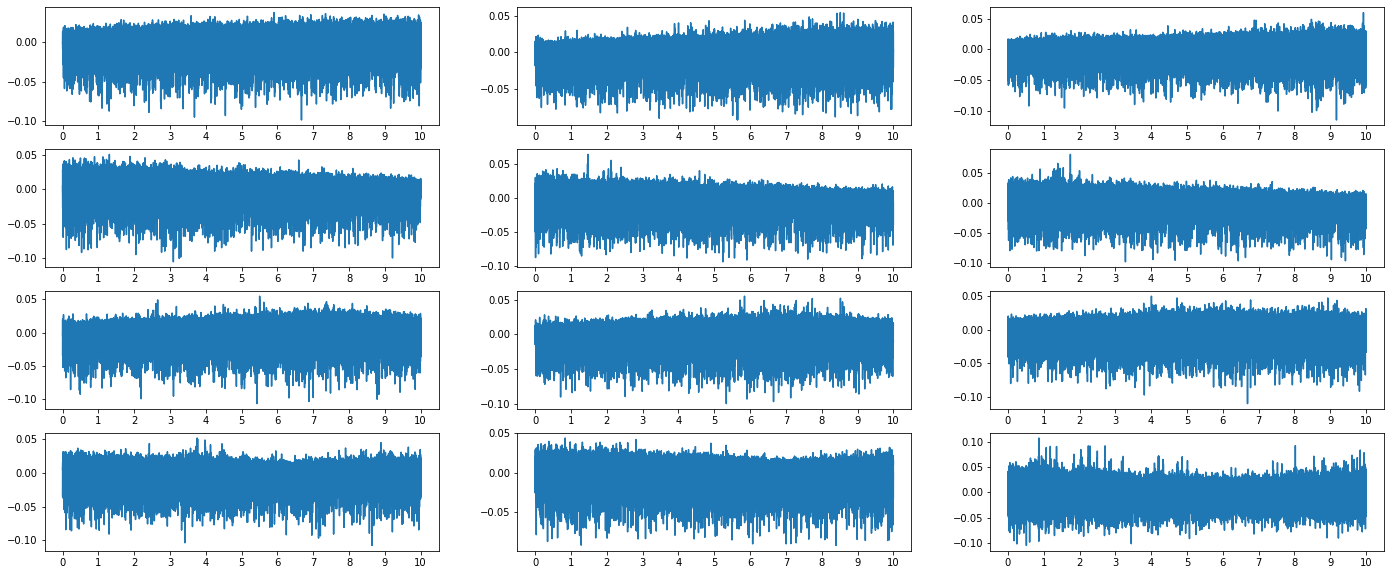

In [ ]:
#healthy bearing

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i])
  #plt.xticks([0,200000,400000,600000,800000,1000000,1200000,1400000,1600000,1800000,2000000], [0,1,2,3,4,5,6,7,8,9,10])
  #plt.xlabel('time(s)')

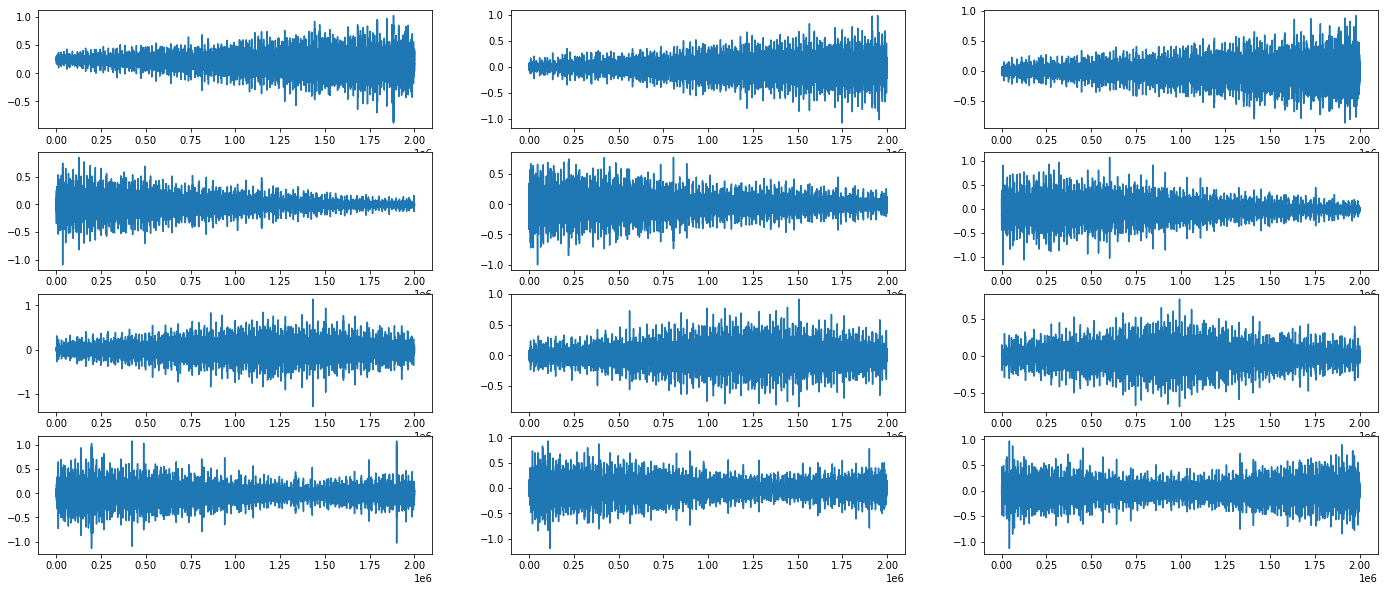

In [ ]:
#inner race fault 

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+12])

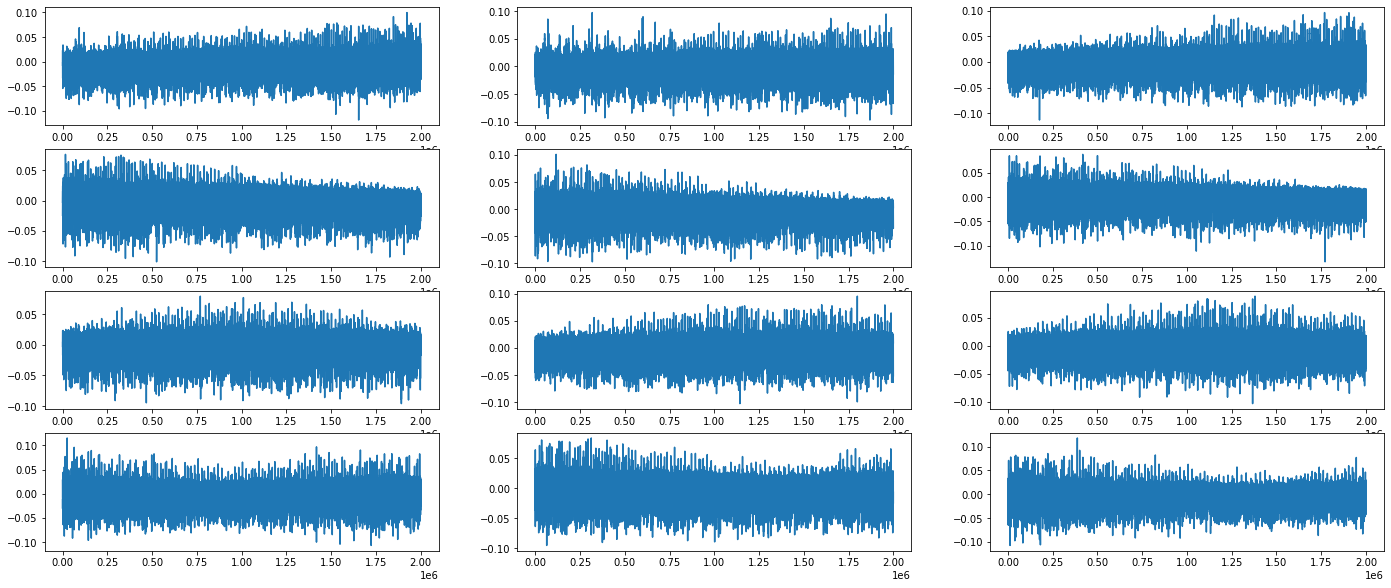

In [ ]:
#outer race fault

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+24])

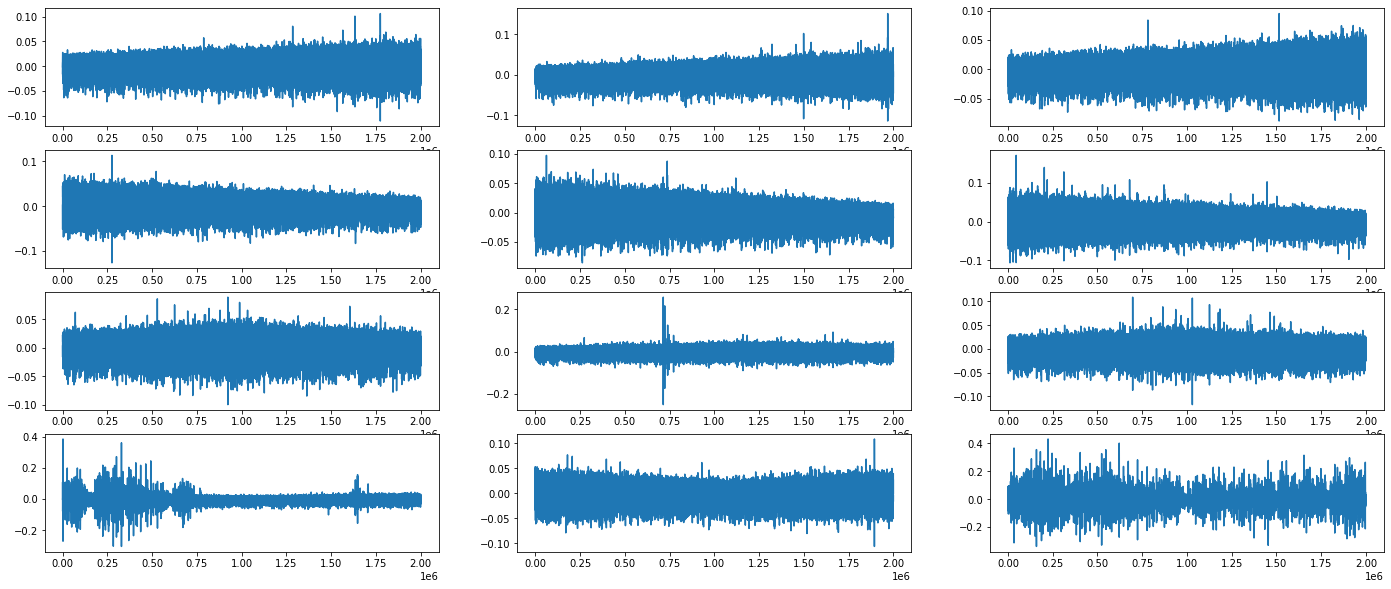

In [ ]:
#ball fault

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+36])

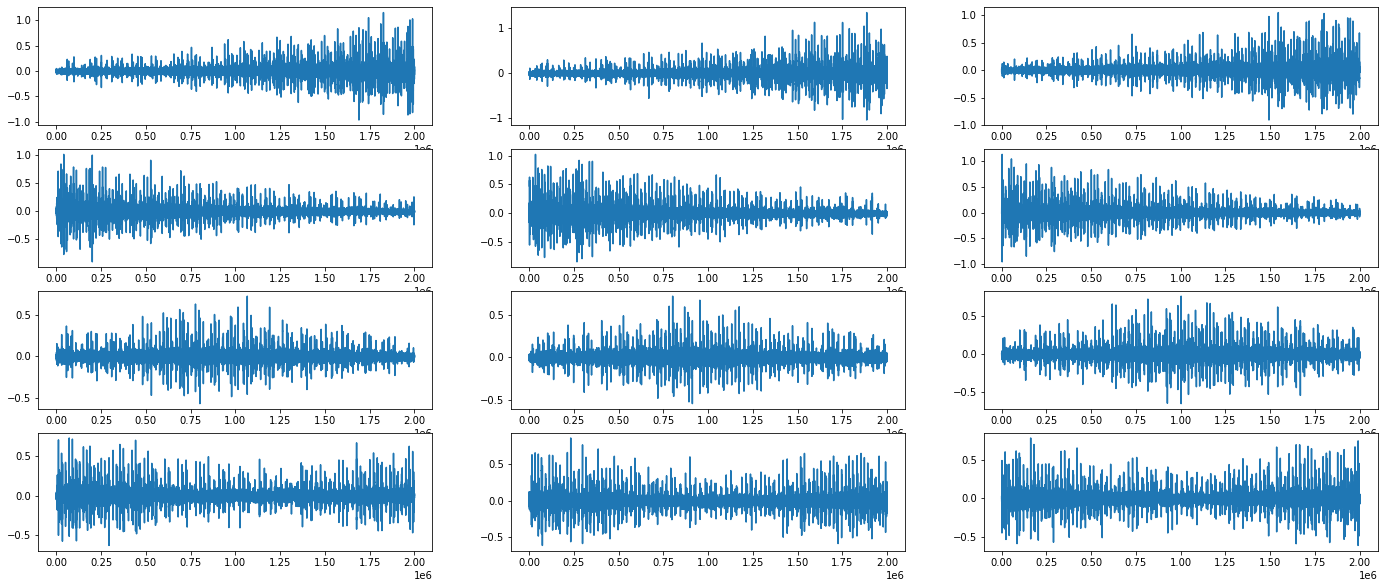

In [ ]:
#combination of faults

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+48])

#### 베어링 상태별 FFT 그래프

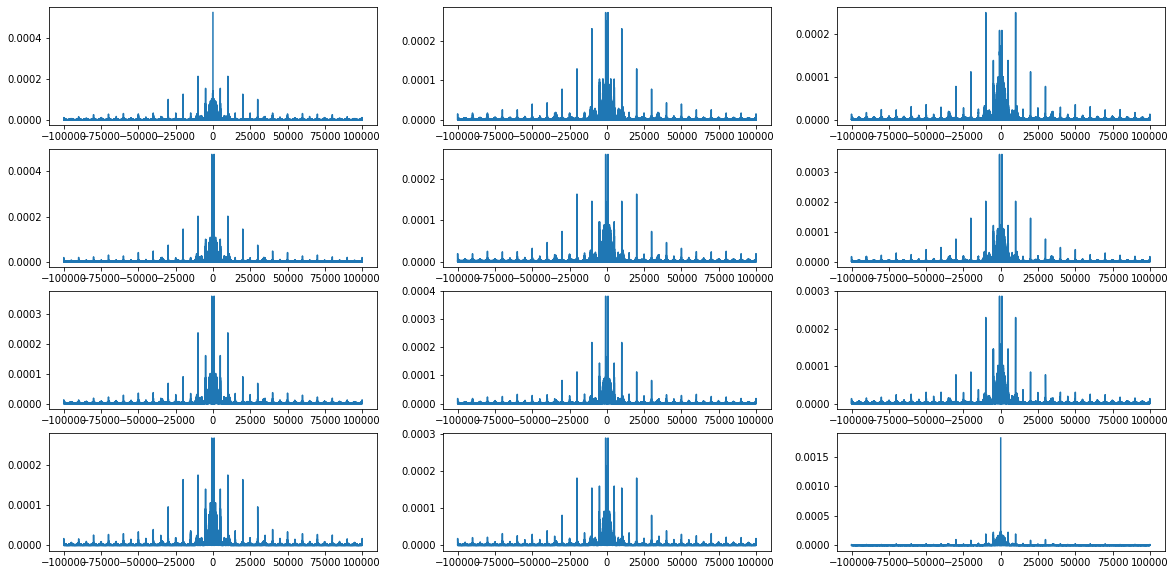

In [ ]:
#healthy bearing

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i]))

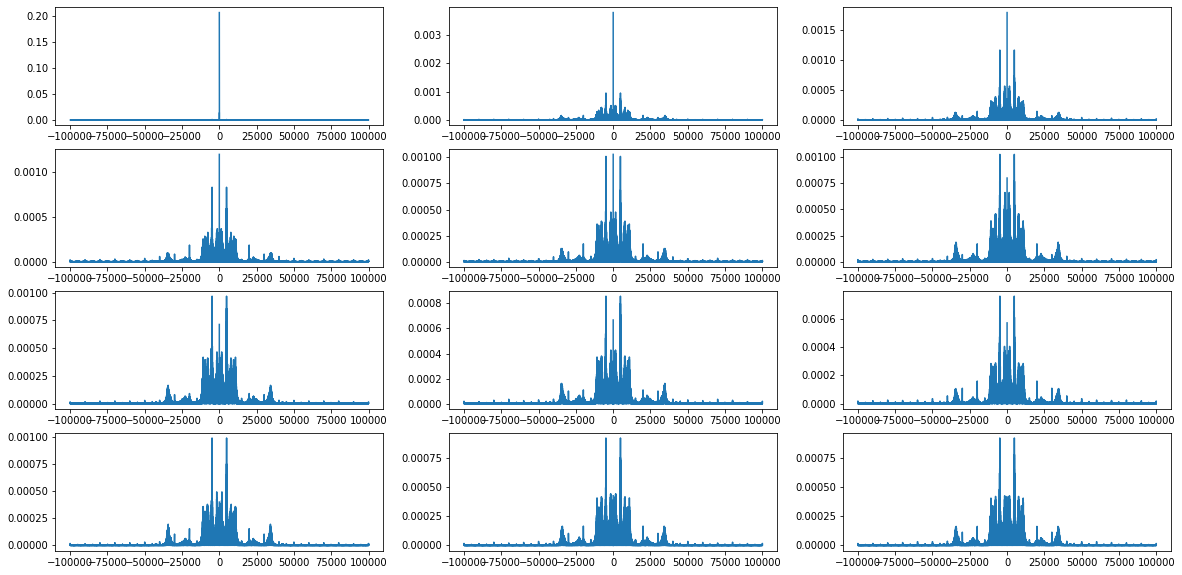

In [ ]:
#inner race fault 

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+12]))

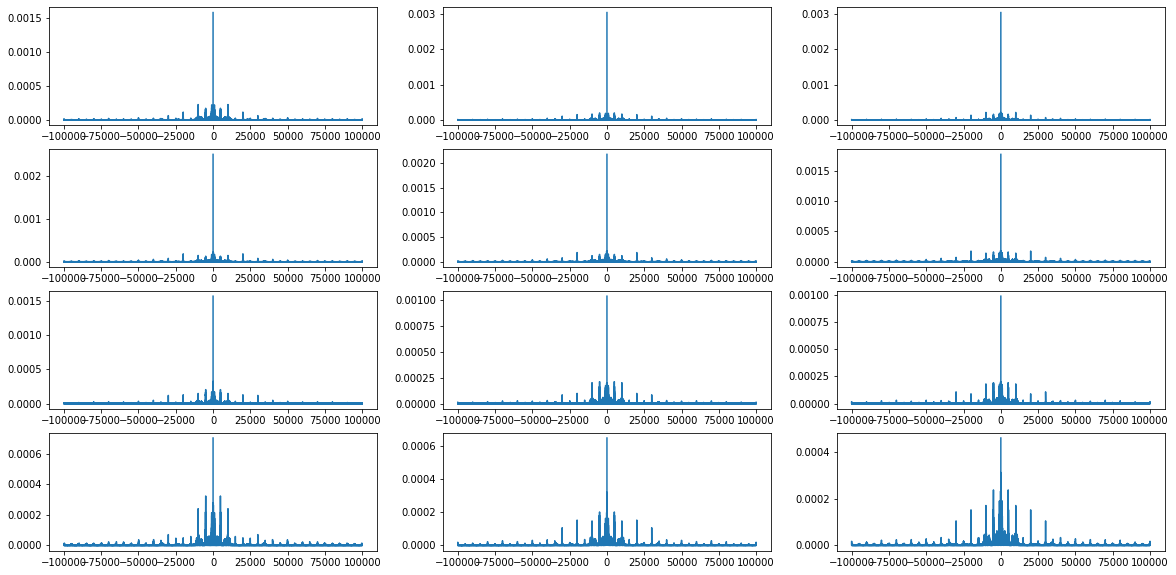

In [ ]:
#outer race fault

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+24]))

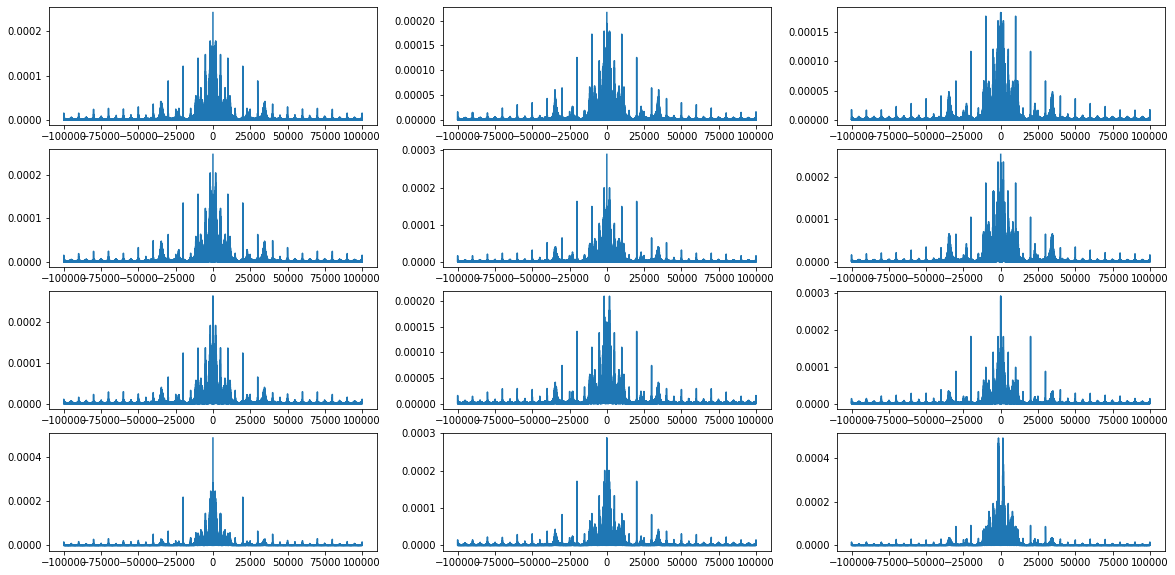

In [ ]:
#ball fault

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+36]))

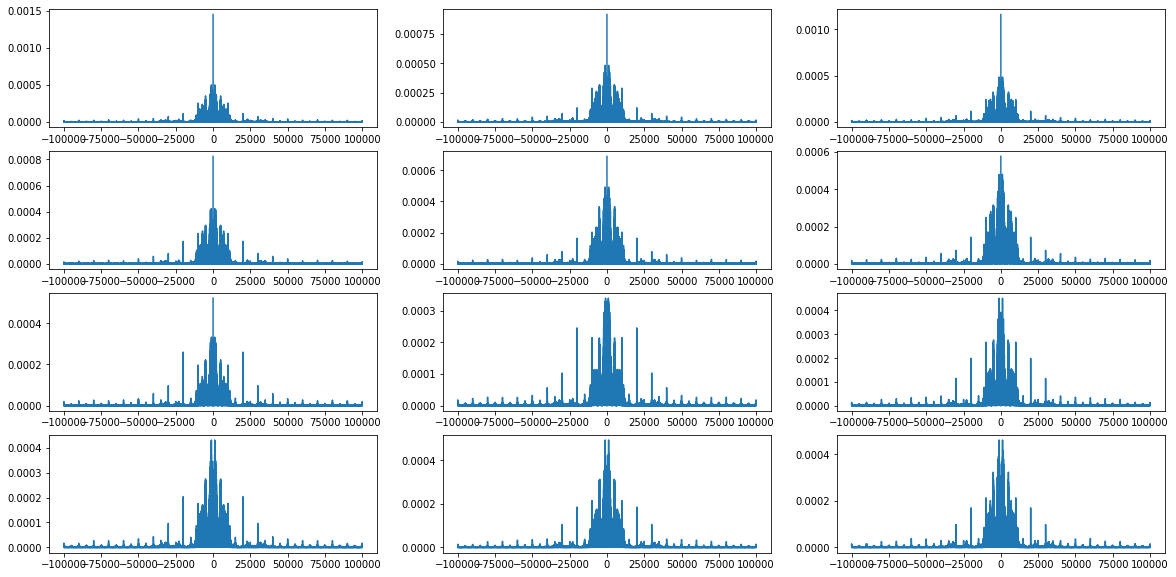

In [ ]:
#combination of faults

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+48]))

#### 베어링 속도별 평균 FFT 그래프

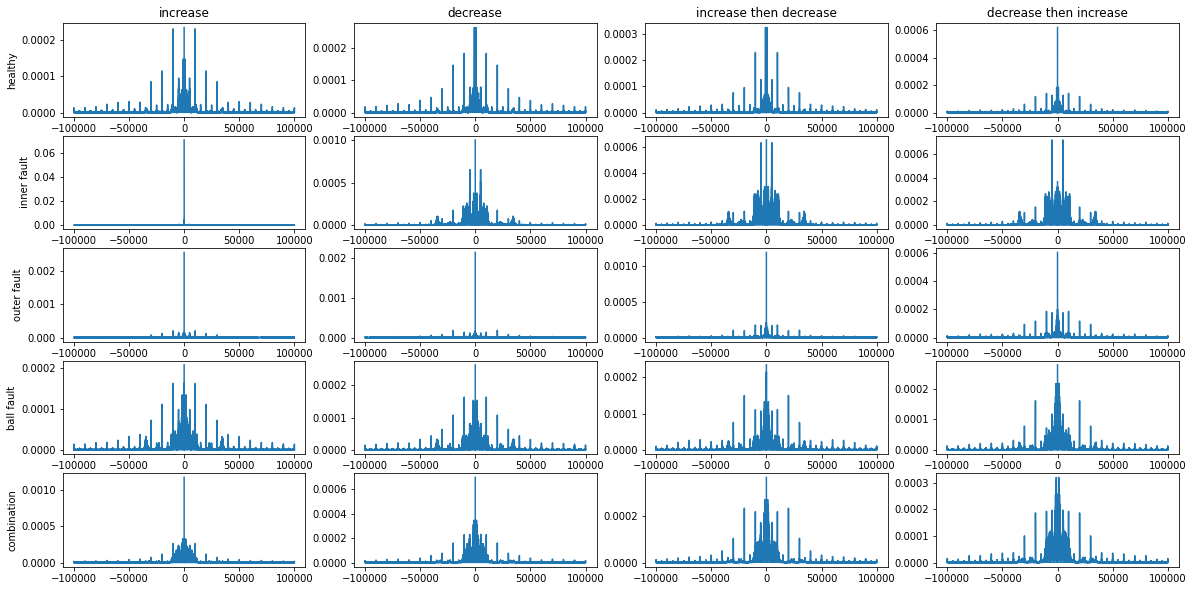

In [ ]:
plt.figure(figsize=(20,10))

for i in range(20):
  plt.subplot(5,4,i+1)
  plt.plot(freq, np.average(abs(raw_fft[3*i:3*(i+1)]), axis=0))

  if i==0: plt.title('increase'); plt.ylabel('healthy')
  elif i==1: plt.title('decrease')
  elif i==2: plt.title('increase then decrease')
  elif i==3: plt.title('decrease then increase')
  elif i==4: plt.ylabel('inner fault')
  elif i==8: plt.ylabel('outer fault')
  elif i==12: plt.ylabel('ball fault')
  elif i==16: plt.ylabel('combination')
  
plt.show()

#### 베어링 속도별 평균 STFT 그래프

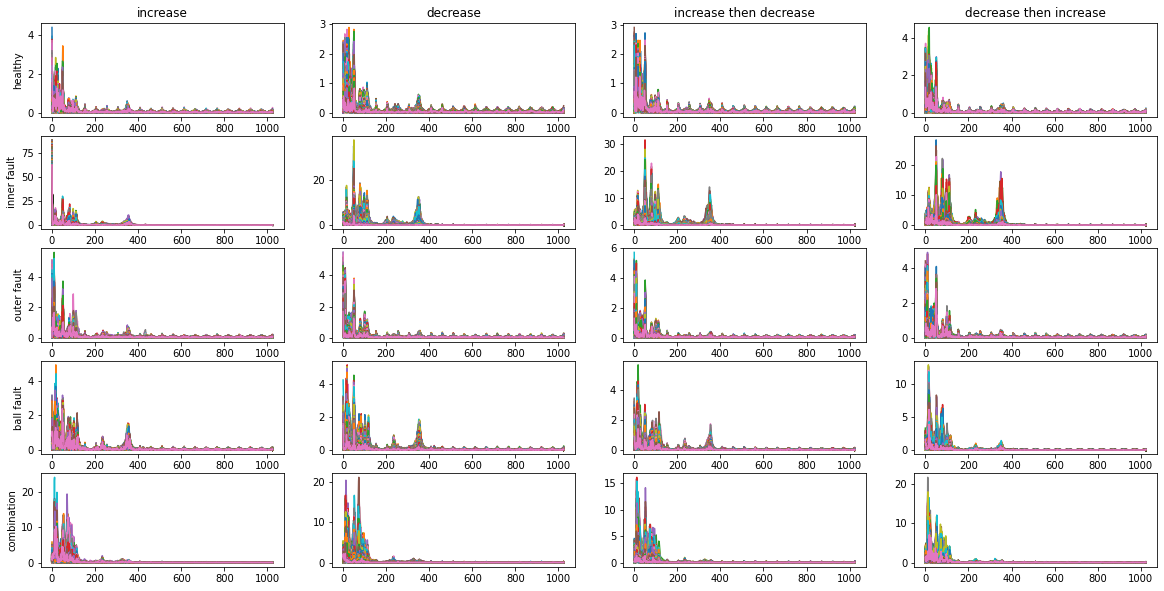

In [ ]:
plt.figure(figsize=(20,10))

for i in range(20):
  plt.subplot(5,4,i+1)
  plt.plot(abs(librosa.stft((np.average(raw[3*i:3*(i+1)], axis=0)))))
  
  if i==0: plt.title('increase'); plt.ylabel('healthy')
  elif i==1: plt.title('decrease')
  elif i==2: plt.title('increase then decrease')
  elif i==3: plt.title('decrease then increase')
  elif i==4: plt.ylabel('inner fault')
  elif i==8: plt.ylabel('outer fault')
  elif i==12: plt.ylabel('ball fault')
  elif i==16: plt.ylabel('combination')
  
plt.show()

## 전에 쓰던 전처리 코드

In [ ]:
#50초 정도 소요
raw=[]
file_names=['H-A-1.mat','H-A-2.mat','H-A-3.mat','H-B-1.mat','H-B-2.mat','H-B-3.mat','H-C-1.mat','H-C-2.mat','H-C-3.mat','H-D-1.mat','H-D-2.mat','H-D-3.mat','I-A-1.mat','I-A-2.mat','I-A-3.mat','I-B-1.mat','I-B-2.mat','I-B-3.mat','I-C-1.mat','I-C-2.mat','I-C-3.mat','I-D-1.mat','I-D-2.mat','I-D-3.mat','O-A-1.mat','O-A-2.mat','O-A-3.mat','O-B-1.mat','O-B-2.mat','O-B-3.mat','O-C-1.mat','O-C-2.mat','O-C-3.mat','O-D-1.mat','O-D-2.mat','O-D-3.mat','B-A-1.mat','B-A-2.mat','B-A-3.mat','B-B-1.mat','B-B-2.mat','B-B-3.mat','B-C-1.mat','B-C-2.mat','B-C-3.mat','B-D-1.mat','B-D-2.mat','B-D-3.mat', 'C-A-1.mat','C-A-2.mat','C-A-3.mat','C-B-1.mat','C-B-2.mat','C-B-3.mat','C-C-1.mat','C-C-2.mat','C-C-3.mat','C-D-1.mat','C-D-2.mat','C-D-3.mat']

for i in range(60):
  mat_file = io.loadmat(file_path+file_names[i])['Channel_1'].reshape(2000000)
  raw.append(mat_file)

raw=np.array(raw)

In [ ]:
#5초 정도 소요
raw_fft=[]

for i in range(60):
  fft=np.fft.fft(raw[i])/N
  raw_fft.append(fft)

raw_fft=np.array(raw_fft)

In [ ]:
raw_100=[]

for i in range(60):
  res=raw[i].reshape(1000,2000)
  for j in range(1000):
    raw_100.append(res[j])

raw_100=np.array(raw_100)

In [ ]:
raw_fft_100=[]

for i in range(60000):
  fft=np.fft.fft(raw_100[i])/2000
  raw_fft_100.append(fft)

raw_fft_100=np.array(raw_fft_100)

## 전에 쓰던 함수

In [ ]:
def show(data):
    plt.figure(figsize=(20,5))
    plt.plot(range(2000000), data)

In [ ]:
def during(data,a,b):
    start=a
    end=b
    new_data=data[int(200000*a):int(200000*b)]

    plt.figure(figsize=(20,5))
    plt.plot(range(int(200000*(b-a))), new_data)
    plt.show()

In [ ]:
def fft(data, n=N):
    time=np.arange(0,10,1/Fs)
    Y=np.fft.fft(data)/N
    Y_mag=np.abs(Y)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.plot(time[:n], data[:n])
    plt.subplot(2,1,2)
    plt.stem(Y_mag[:n])
    plt.show()

In [ ]:
def draw_stft(f, t, Zxx):
    plt.figure(figsize=(12,5))
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
    plt.title('STFT Magnitude'); plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]'); plt.ylim([0, 100000]); plt.show()

def stft(data, x):
  f,t,Zxx=signal.stft(data, fs=200000, nperseg=x)
  draw_stft(f,t,Zxx)

# Fs=sampling frequency
# window size를 0.1s로 하려면 nperseg를 Fs*0.1로 설정하면 됨

f,t,Zxx=signal.stft(raw[0], fs=200000, nperseg=1000)